## Hank Snowdon 
### Research Project for GISC 38400 
### Spring 2024

### Imports 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns

import geopandas as gpd
import osmnx as ox
from r5py import TransportNetwork
import datetime

import matplotlib.cm as cm
import matplotlib.colors as mcolors

import contextily as cx

pd.options.display.max_columns = None

#### Demographic/Census Data

In [2]:
# 2020 Census Data - from NHGIS 
nhgis_2020_geo = gpd.read_file('Data/Chi_SS_block_2020.shp').to_crs(32616) # This file was manually manipulated in QGIS to reduce its geographic size to the South Side 
nhgis_2020 = pd.read_csv('Data/nhgis0001_csv/nhgis0001_ds258_2020_block.csv')
nhgis_2020_cook = nhgis_2020[nhgis_2020['COUNTY'] == 'Cook County']

# Merge 
nhgis_2020_merged = nhgis_2020_geo.merge(nhgis_2020_cook, on='GISJOIN', how='inner') 
nhgis_2020_merged['id'] = nhgis_2020_merged.reset_index(drop=True).index

# Rename columns 
nhgis_2020_merged['WhitePop'] = nhgis_2020_merged['U7J002']
nhgis_2020_merged['NonWhitePop'] = nhgis_2020_merged['U7J001'] - nhgis_2020_merged['U7J002']
nhgis_2020_merged['NonWhitePercent'] = nhgis_2020_merged['NonWhitePop']/ (nhgis_2020_merged['WhitePop'] + nhgis_2020_merged['NonWhitePop'])

# Create points out of the centroid of every Census Block
points_Chi = nhgis_2020_merged.copy()
points_Chi["geometry"] = points_Chi.centroid 

/var/folders/hy/7bg3p3w97zz61h5wn9hhp18h0000gn/T/ipykernel_1198/3892074200.py:3: DtypeWarning: Columns (40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  nhgis_2020 = pd.read_csv('Data/nhgis0001_csv/nhgis0001_ds258_2020_block.csv')


In [3]:
# 1940 Census Data -- from NHGIS 
nhgis_1940_geo = gpd.read_file('Data/Chi_tract_1940.shp').to_crs(32616) # This file was manually manipulated in QGIS to reduce its geographic size to the South Side 
nhgis_1940 = pd.read_csv('Data/nhgis0003_csv/nhgis0003_ds76_1940_tract.csv')
nhgis_1940_cook = nhgis_1940[(nhgis_1940['COUNTY'] == 'Cook') & (nhgis_1940['STATE'] == 'Illinois') ]

# Merge 
nhgis_1940_merged = nhgis_1940_geo.merge(nhgis_1940_cook, on='GISJOIN', how='inner') 
nhgis_1940_merged['id'] = nhgis_1940_merged.reset_index(drop=True).index

# Rename columns 
# nhgis_1940_merged = nhgis_1940_merged.rename(columns = {'BUQ001': 'WhitePop', 'BUQ002': 'NonWhitePop'})
nhgis_1940_merged['NonWhitePerc'] = nhgis_1940_merged['BUQ002']/ (nhgis_1940_merged['BUQ001'] + nhgis_1940_merged['BUQ002'])
nhgis_1940_merged['Population'] = (nhgis_1940_merged['BUQ001'] + nhgis_1940_merged['BUQ002'])

In [4]:
# Ensure the GeoDataFrames have a common CRS (Coordinate Reference System)
nhgis_1940_merged.crs = nhgis_2020_merged.crs

# Rename GISJOIN columns for clarity
nhgis_1940_merged.rename(columns={'GISJOIN': 'GISJOIN_1940'}, inplace=True)
nhgis_2020_merged.rename(columns={'GISJOIN': 'GISJOIN_2020'}, inplace=True)

# Overlay the 2020 data to the 1940 data using intersection
interpolated_data = gpd.overlay(nhgis_2020_merged, nhgis_1940_merged[['geometry', 'GISJOIN_1940', 'BUQ001','BUQ002', 'NonWhitePerc', 'Population']], how='intersection', keep_geom_type=True)

In [5]:
# Calculate weights for areal interpolation based on the intersection area
interpolated_data['area_intersection'] = interpolated_data['geometry'].area
interpolated_data['weight'] = interpolated_data['area_intersection'] / interpolated_data.groupby('GISJOIN_1940')['area_intersection'].transform('sum')

# Perform areal interpolation for the target variables
interpolated_data['BUQ001_1940_interpolated'] = interpolated_data['BUQ001'] * interpolated_data['weight']
interpolated_data['BUQ002_1940_interpolated'] = interpolated_data['BUQ002'] * interpolated_data['weight']
interpolated_data['Population_1940_interpolated'] = interpolated_data['Population'] * interpolated_data['weight']

# Aggregate the interpolated values by the 2020 block boundaries
nhgis_2020_interpolated = interpolated_data.groupby('GISJOIN_2020')[['BUQ001_1940_interpolated', 'BUQ002_1940_interpolated', 'Population_1940_interpolated']].sum().reset_index()

# Merge the interpolated values back to the 2020 GeoDataFrame
nhgis_2020_interpolated = nhgis_2020_merged.merge(nhgis_2020_interpolated, on='GISJOIN_2020', how='left')

# Calculate the percentage change in white and nonwhite 
nhgis_2020_interpolated['PCT_W_CHG'] = (nhgis_2020_interpolated['WhitePop'] - nhgis_2020_interpolated['BUQ001_1940_interpolated'] ) / nhgis_2020_interpolated['BUQ001_1940_interpolated']
nhgis_2020_interpolated['PCT_NW_CHG'] = (nhgis_2020_interpolated['NonWhitePop'] - nhgis_2020_interpolated['BUQ002_1940_interpolated'] ) / nhgis_2020_interpolated['BUQ002_1940_interpolated']
nhgis_2020_interpolated['PCT_NW_PCT_CHG'] = (nhgis_2020_interpolated['NonWhitePercent'] - (nhgis_2020_interpolated['BUQ002_1940_interpolated']/ (nhgis_2020_interpolated['BUQ002_1940_interpolated']+ nhgis_2020_interpolated['BUQ002_1940_interpolated']))) / (nhgis_2020_interpolated['BUQ002_1940_interpolated']/ (nhgis_2020_interpolated['BUQ002_1940_interpolated']+ nhgis_2020_interpolated['BUQ002_1940_interpolated']))
nhgis_2020_interpolated['PCT_POP_CHG'] = (nhgis_2020_interpolated['U7H001'] - nhgis_2020_interpolated['Population_1940_interpolated'] ) / nhgis_2020_interpolated['Population_1940_interpolated']


In [6]:
# Export for mapping
nhgis_2020_interpolated.to_file("Data/TravelTimeExports/nhgis_2020_interpolated.geojson", driver='GeoJSON')

In [7]:
# Create points out of the centroid of every Census Block
points_Chi = nhgis_2020_interpolated.copy()
points_Chi["geometry"] = points_Chi.centroid 

#### Routing Data 

In [38]:
# OpenStreetMap
from pyrosm import get_data
# Download data for the city of Chicago
chicago_osm = get_data("chicago", directory = 'data') 

In [39]:
# GTFS
# From transitfeeds website
chicago_gtfs = "Data/chicago_gtfs_dec23.zip" 

In [ ]:
# Walking network 
transport_network_walk_Chi = TransportNetwork( 
    chicago_osm 
)

In [ ]:
# Transit network 
transport_network_transit_Chi = TransportNetwork(
    # OSM data
    chicago_osm,  
    # GTFS data   
    [chicago_gtfs]
)

#### Transit Station Point Data 

In [10]:
# L stations 1941
SS_EL_1941 = gpd.read_file('Data/L_Stops_Historic/L_Stops_Historic_Shpfile.shp')
SS_EL_1941 = SS_EL_1941.reset_index()
SS_EL_1941["id"] = SS_EL_1941.index

# L stations 1941
SS_EL_1960 = gpd.read_file('Data/L_Stops_1960/L_Stops_1960_Shpfile.shp')
SS_EL_1960 = SS_EL_1960.reset_index()
SS_EL_1960["id"] = SS_EL_1960.index

# Current L stations 2024
Current_L = gpd.read_file('Data/CTA_RailStations/CTA_RailStations.shp')
Current_L = Current_L.reset_index()
Current_L["id"] = Current_L.index

# Current L stations 2024 South Side 
Current_L_SS = gpd.read_file('Data/CTA_RailStations/CTA_RailStations_SS.shp')
Current_L_SS = Current_L_SS.reset_index()
Current_L_SS["id"] = Current_L_SS.index

# Candidate re-instatements
Branches_SSL = gpd.read_file('Data/L_Stops_Historic/Missing_Original SSL Stations.shp')
Branches_SSL = Branches_SSL.reset_index()
Branches_SSL["id"] = Branches_SSL.index

# Candidate infill 
Infill_SSL = gpd.read_file('Data/L_Stops_Historic/Missing_Original SSL Stations OnLine.shp')
Infill_SSL = Infill_SSL.reset_index()
Infill_SSL["id"] = Infill_SSL.index

#### Create function to perform travel time analysis

In [ ]:
from r5py import TravelTimeMatrixComputer, TransportMode

In [13]:
def accessability_analysis(network, origins, destinations, time, modes, census, timelim, threshold, demo_col, title, show_maps = True):

    plt.ioff()

    # Create travel time matrix
    travel_time_matrix_computer =  TravelTimeMatrixComputer(
    network,
    origins=origins,
    destinations=destinations,
    departure=time,
        transport_modes=modes
    )

    travel_time_matrix = travel_time_matrix_computer.compute_travel_times()

    closest_stops = travel_time_matrix.groupby("to_id")["travel_time"].min().reset_index()

    # Merge with demographic data 
    geo = census.merge(closest_stops, left_on="id", right_on="to_id")
    geo['travel_time'] = geo['travel_time'] + 1 # Add a minute to all travel times to account for variability inside a block/time to enter station and prevent 0 min times

    # Create main distances map
    distancemap = geo[geo['travel_time']< timelim].plot(column="travel_time", cmap="RdYlBu", scheme="natural_breaks", k=10, legend=True, figsize=(10,10))
    distancemap.set_title(title)


    # Create access map
    access = geo.loc[geo["travel_time"]<=threshold].copy()
    accessmap2 = access.plot(column=demo_col, figsize=(10,5), legend=True)
    accessmap2.set_title(f"{demo_col} living within {threshold} minutes travel time threshold.")

    plt.ion()

    if not show_maps: 
            plt.close('all')

    if show_maps == True:
        return geo, distancemap, accessmap2, access
    else:
        return geo, access 

#### Calculate convex hull around 30 min walking access to 1941 stations

In [14]:
data_W_1941,  access_W_1941 = accessability_analysis(transport_network_transit_Chi, SS_EL_1941, points_Chi, datetime.datetime(2023,12,22,8,30), [TransportMode.WALK], nhgis_2020_merged, 45, 30, "U7H001", title = "Walking Accessability to SS Elevated 1941", show_maps = False)

In [15]:
SS_30min_1941 = access_W_1941['GISJOIN_2020']
SS_30min_1941_points = points_Chi[points_Chi['GISJOIN_2020'].isin(SS_30min_1941)]
SS_30min_1941_points['xcoord'] = SS_30min_1941_points['geometry'].apply(lambda point: point.x)
SS_30min_1941_points['ycoord'] = SS_30min_1941_points['geometry'].apply(lambda point: point.y)
SS_30min_1941_points = SS_30min_1941_points[['xcoord','ycoord']] 

In [16]:
from pointpats import centrography
import pysal.lib

# Extract coordinates  
coordinates = SS_30min_1941_points[['xcoord','ycoord']].values

# Calculate convex hull and alpha shape
convex_hull_vertices = centrography.hull(coordinates)
alpha_shape, alpha, circs = pysal.lib.cg.alpha_shape_auto(coordinates, return_circles=True)

In [17]:
from shapely.geometry import Polygon, Point

# Create a Polygon object from the convex hull vertices and subset points_chi
convex_hull_polygon = Polygon(convex_hull_vertices)
points_1941_hull_W_30 = points_Chi[points_Chi['geometry'].apply(lambda geometry: convex_hull_polygon.contains(Point(geometry.x, geometry.y)))]
nhgis_2020_interpolated_hull = nhgis_2020_interpolated[nhgis_2020_interpolated['GISJOIN_2020'].isin(points_1941_hull_W_30['GISJOIN_2020'])]

In [18]:
# Export 
nhgis_2020_interpolated_hull.to_file("Data/TravelTimeExports/nhgis_2020_interpolated_hull.geojson", driver='GeoJSON')

# Quantitative Analysis

In [87]:
# GO TO COLORBREWER TO PICK COLORS FOR PROJECT

### 1. Difference in the proportion of people in the South Side who lived within a 10, 20, and 30-minute walk of the South Side L before and after the CTA modernization of the 1950s

In [148]:
# Function that plots difference in blocks which are within 'time' minutes of points_before and points_after
# Used in this project to plot difference in blocks with/without access to transit after CTA closed stations/branches in 1950s

def prop_diff(points_before, points_after, time, variable, year1, year2, method = [TransportMode.WALK]):

    _, ab = accessability_analysis(transport_network_transit_Chi, points_before, points_Chi, datetime.datetime(2023,12,22,8,30), method, nhgis_2020_interpolated, 60, time, variable, title = f"Walking Accessability to SS Elevated {year1}", show_maps = False)
    _, aa = accessability_analysis(transport_network_transit_Chi, points_after, points_Chi, datetime.datetime(2023,12,22,8,30), method, nhgis_2020_interpolated, 60, time, variable, title = f"Walking Accessability to SS Elevated {year2}", show_maps = False)

    pop_within_threshold1 = ab[variable].sum()
    pop_share1 = pop_within_threshold1 / nhgis_2020_interpolated_hull[variable].sum()   
    print(f"Population within accessibility thresholds {year1}: {int(pop_within_threshold1)} ({pop_share1*100:.0f} %)")

    pop_within_threshold2 = aa[variable].sum()
    pop_share2 = pop_within_threshold2 / nhgis_2020_interpolated_hull[variable].sum()   
    print(f"Population within accessibility thresholds {year2}: {int(pop_within_threshold2) } ({pop_share2*100:.0f} %)")   

    diff = ((pop_share2 - pop_share1)*100).round(2)
    print(f"Difference in access via {time} minute walk before and after CTA Modernization was {diff} %")

    # Get the total bounds of ab and aa GeoDataFrames
    ab_bounds = ab.total_bounds
    aa_bounds = aa.total_bounds

    # Define the xlim and ylim based on the total bounds
    xlim = (min(ab_bounds[0], aa_bounds[0]), max(ab_bounds[2], aa_bounds[2]))
    ylim = (min(ab_bounds[1], aa_bounds[1]), max(ab_bounds[3], aa_bounds[3]))

    fig, axes = plt.subplots(1, 2, figsize=(10, 10))

    # define min and max values and colormap for the plots
    value_min = 0
    value_max = 2500
    cmap = 'viridis'

# Plot the first subplot
    cx.add_basemap(ab.plot(ax=axes[0], column=variable, legend=False, vmin=value_min, vmax=3000, cmap=cmap), crs=nhgis_2020_merged.crs, source=cx.providers.OpenStreetMap.Mapnik )
    axes[0].set_title(f"{year1}") 
    axes[0].set_axis_off()
    axes[0].set_xlim(xlim)
    axes[0].set_ylim(ylim)

    # Plot the second subplot
    cx.add_basemap(aa.plot(ax=axes[1], column=variable, legend=False, vmin=value_min, vmax=3000, cmap=cmap), crs=nhgis_2020_merged.crs, source=cx.providers.OpenStreetMap.Mapnik )
    axes[1].set_title(f"{year2}") 
    axes[1].set_axis_off()
    axes[1].set_xlim(xlim)
    axes[1].set_ylim(ylim)


    mappable = cm.ScalarMappable(
        norm=mcolors.Normalize(value_min, value_max),
        cmap=cmap)
    
    # define position and extent of colorbar
    cb_ax = fig.add_axes([1, 0.15, 0.03, .7])  # Adjust the position as needed

    # draw colorbar
    cbar = fig.colorbar(mappable, cax=cb_ax, orientation='vertical')
    cbar.set_label('1940 Interpolated Population', labelpad=10)

    plt.suptitle(f"Resedential Census Block centroids within a {time} minute walk of the South Side Elevated pre and post-CTA Modernization")   

    plt.tight_layout()
    plt.show()

10 min

Population within accessibility thresholds 1941: 229063 (32 %)
Population within accessibility thresholds 1960: 169660 (24 %)
Difference in access via 10 minute walk before and after CTA Modernization was -8.24 %


/var/folders/hy/7bg3p3w97zz61h5wn9hhp18h0000gn/T/ipykernel_74027/443881013.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


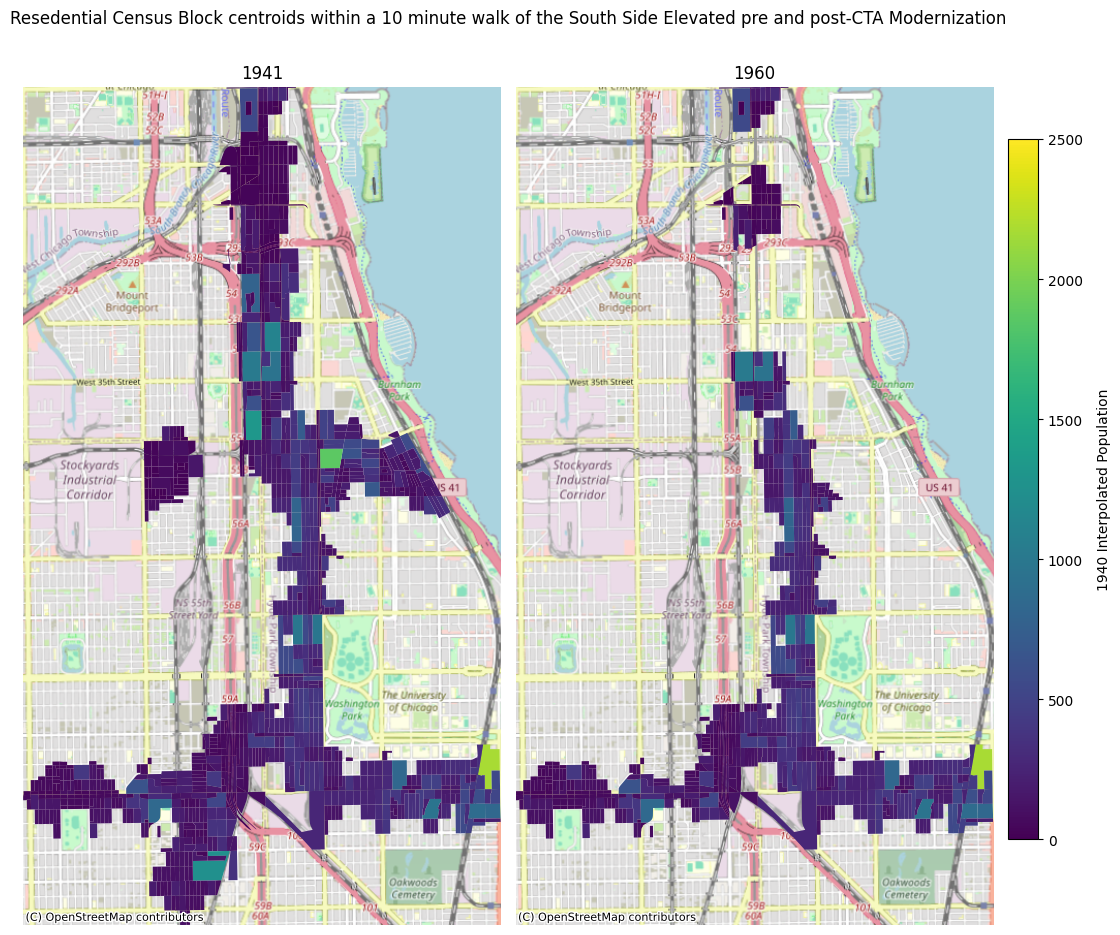

In [174]:
prop_diff(SS_EL_1941, SS_EL_1960, 10, 'Population_1940_interpolated', 1941, 1960)

15 min

Population within accessibility thresholds 1941: 359115 (50 %)
Population within accessibility thresholds 1960: 275461 (38 %)
Difference in access via 15 minute walk before and after CTA Modernization was -11.61 %


/var/folders/hy/7bg3p3w97zz61h5wn9hhp18h0000gn/T/ipykernel_74027/443881013.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


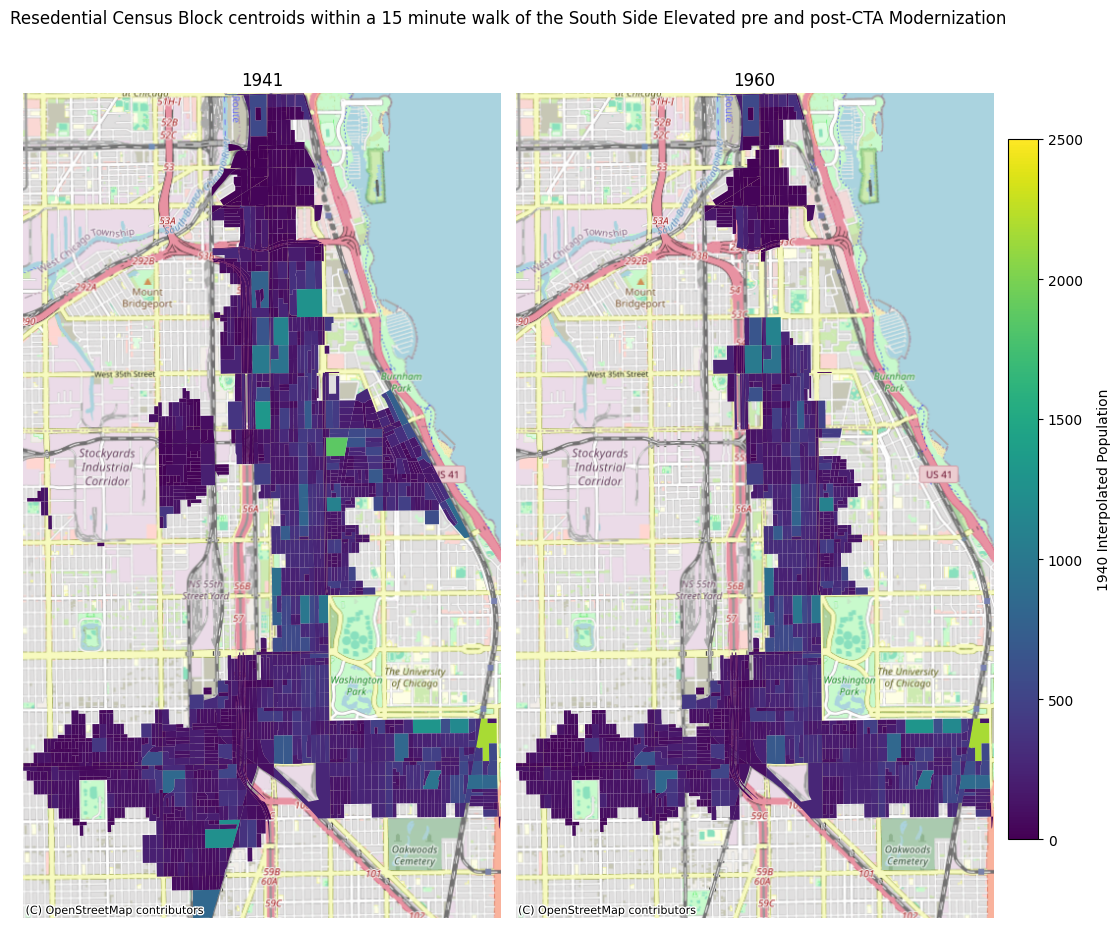

In [153]:
prop_diff(SS_EL_1941, SS_EL_1960, 15, 'Population_1940_interpolated', 1941, 1960)

20 min

Population within accessibility thresholds 1941: 453536 (63 %)
Population within accessibility thresholds 1960: 355805 (49 %)
Difference in access via 20 minute walk before and after CTA Modernization was -13.56 %


/var/folders/hy/7bg3p3w97zz61h5wn9hhp18h0000gn/T/ipykernel_74027/443881013.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


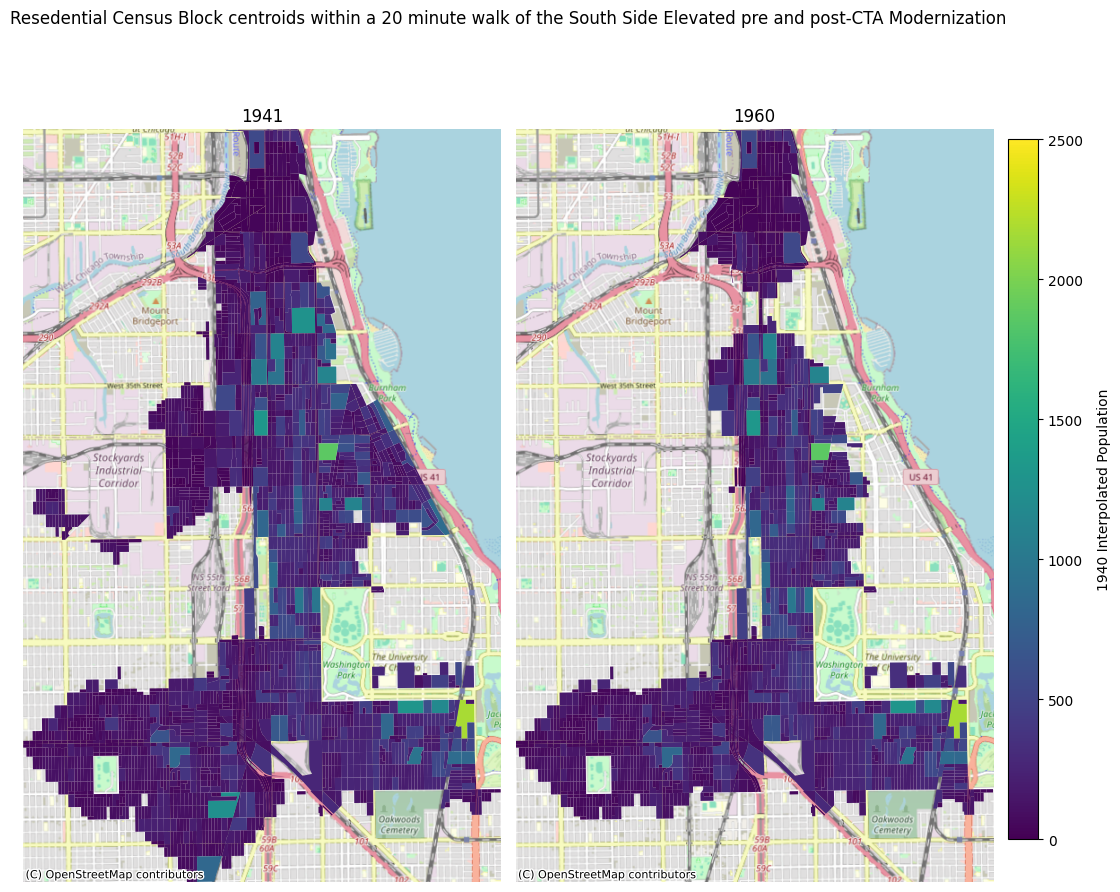

In [151]:
prop_diff(SS_EL_1941, SS_EL_1960, 20, 'Population_1940_interpolated', 1941, 1960)

25 min

Population within accessibility thresholds 1941: 545664 (76 %)
Population within accessibility thresholds 1960: 438894 (61 %)
Difference in access via 25 minute walk before and after CTA Modernization was -14.82 %


/var/folders/hy/7bg3p3w97zz61h5wn9hhp18h0000gn/T/ipykernel_74027/443881013.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


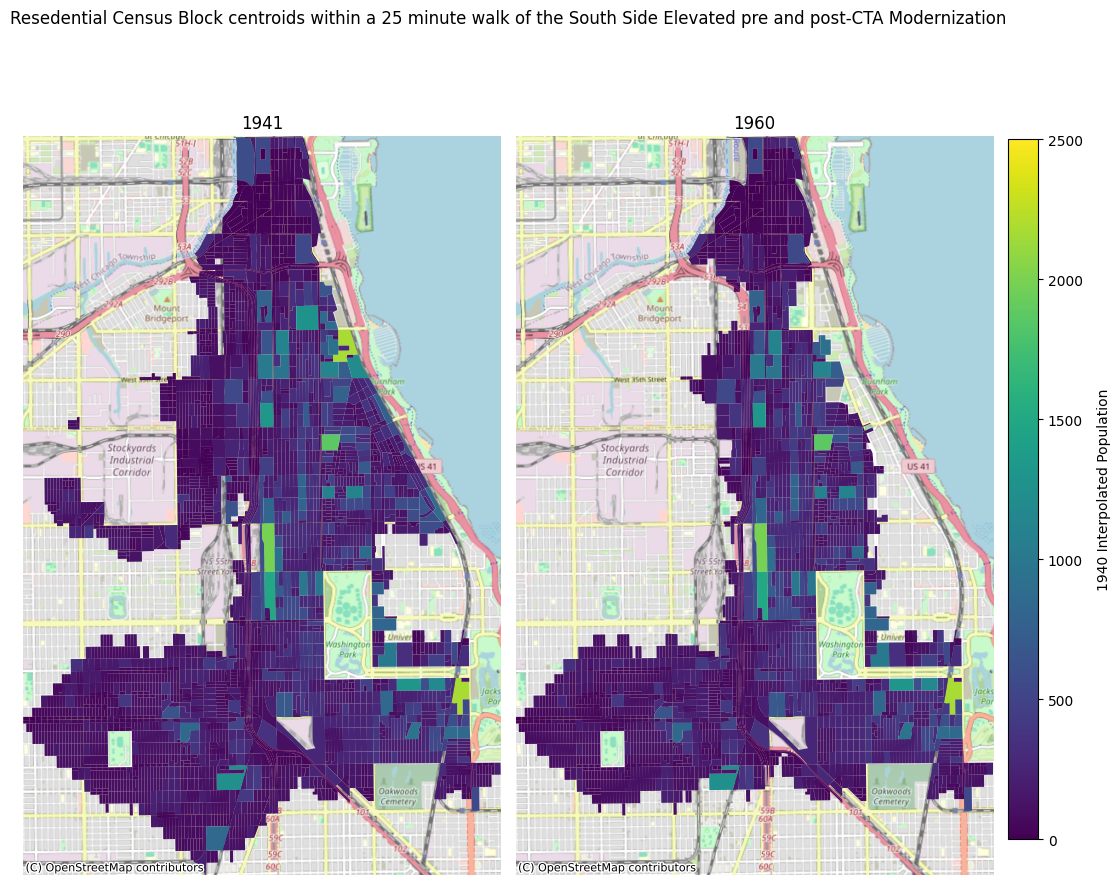

In [152]:
prop_diff(SS_EL_1941, SS_EL_1960, 25, 'Population_1940_interpolated', 1941, 1960)

30 min

Population within accessibility thresholds 1941: 615532 (85 %)
Population within accessibility thresholds 1960: 519683 (72 %)
Difference in access via 30 minute walk before and after CTA Modernization was -13.3 %


/var/folders/hy/7bg3p3w97zz61h5wn9hhp18h0000gn/T/ipykernel_74027/443881013.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


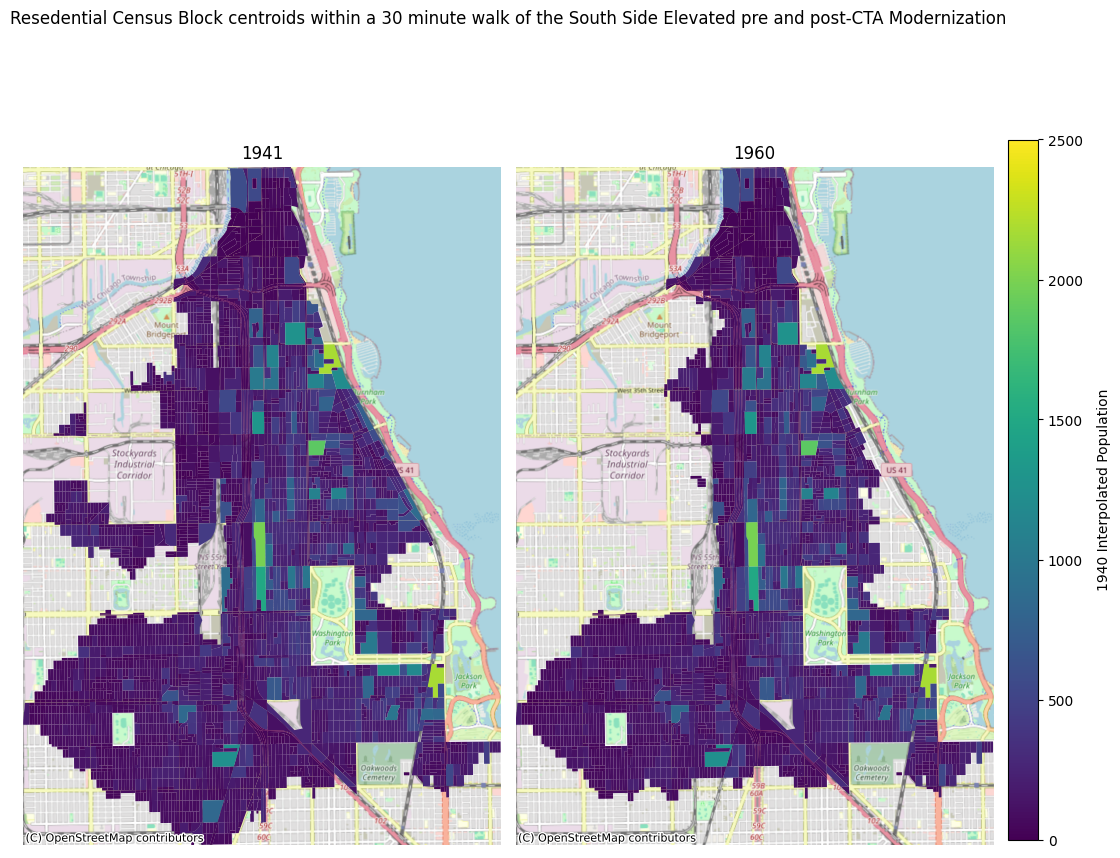

In [150]:
prop_diff(SS_EL_1941, SS_EL_1960, 30, 'Population_1940_interpolated', 1941, 1960)

### 2. Regressions

First regression analysis regresses differences in travel time between 1940 and 1960 on race and population by block.

In [356]:
# Create walking distance data 
data_W_1941,  access_W_1941 = accessability_analysis(transport_network_transit_Chi, SS_EL_1941, points_Chi, datetime.datetime(2023,12,22,8,30), [TransportMode.WALK], nhgis_2020_interpolated_hull, 1000, 30, "U7H001", title = "Walking Accessability to SS Elevated 1941", show_maps = False)
data_W_1960,  access_W_1960 = accessability_analysis(transport_network_transit_Chi, SS_EL_1960, points_Chi, datetime.datetime(2023,12,22,8,30), [TransportMode.WALK], nhgis_2020_interpolated_hull, 1000, 30, "U7H001", title = "Walking Accessability to SS Elevated 1941", show_maps = False)

In [357]:
# Merge pre-and post CTA modernization travel time data
data_modernization_walk = data_W_1941[[
    'GISJOIN_2020', 'geometry',  
    'BUQ001_1940_interpolated',	'BUQ002_1940_interpolated',	
    'Population_1940_interpolated',	 'travel_time'
    ]].merge(
        data_W_1960[['GISJOIN_2020','travel_time']], 
        on='GISJOIN_2020', how='left') 

In [358]:
# Create percent variables 
data_modernization_walk['PCT_NONWHITE'] = 100 * data_modernization_walk['BUQ002_1940_interpolated'] / data_modernization_walk['Population_1940_interpolated'] 
data_modernization_walk['TRAVEL_CHANGE'] = (data_modernization_walk['travel_time_y'] - data_modernization_walk['travel_time_x']) 
data_modernization_walk['PCT_TRAVEL_CHANGE'] = 100 * (data_modernization_walk['travel_time_y'] - data_modernization_walk['travel_time_x']) / data_modernization_walk['travel_time_x'] 
data_modernization_walk['PCT_TRAVEL_CHANGE'] = data_modernization_walk['PCT_TRAVEL_CHANGE'].fillna(0)

data_modernization_walk.drop(columns = ['BUQ001_1940_interpolated',	'BUQ002_1940_interpolated', 'travel_time_x', 'travel_time_y'], axis = 1, inplace = True)

data_modernization_walk.to_file("Data/TravelTimeExports/Modernization_Walk_Times.geojson", driver='GeoJSON')

In [278]:
from pysal.model import spreg
from scipy.stats import boxcox

# List of variable names for regression
variable_names = ['PCT_NONWHITE', 'Population_1940_interpolated' ]
# Shift values to make them positive
data_modernization_walk['PCT_TRAVEL_CHANGE'] = data_modernization_walk['PCT_TRAVEL_CHANGE'] - data_modernization_walk['PCT_TRAVEL_CHANGE'].min() + 1
# Apply Box-Cox transformation
data_modernization_walk['PCT_TRAVEL_CHANGE'], _ = boxcox(data_modernization_walk['PCT_TRAVEL_CHANGE'])

# Fit OLS model
m1 = spreg.OLS(
    # Dep variable
    data_modernization_walk['PCT_TRAVEL_CHANGE'].values,
    # Ind variables
    data_modernization_walk[variable_names].values,
    # Dep variable name
    name_y='PCT_TRAVEL_CHANGE',
    # Ind variable name
    name_x=variable_names,
)
print(m1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :PCT_TRAVEL_CHANGE                Number of Observations:        4264
Mean dependent var  :      1.0554                Number of Variables   :           3
S.D. dependent var  :      1.2343                Degrees of Freedom    :        4261
R-squared           :      0.0223
Adjusted R-squared  :      0.0219
Sum squared residual:     6349.71                F-statistic           :     48.6268
Sigma-square        :       1.490                Prob(F-statistic)     :   1.315e-21
S.E. of regression  :       1.221                Log likelihood        :   -6899.320
Sigma-square ML     :       1.489                Akaike info criterion :   13804.640
S.E of regression ML:      1.2203                Schwarz criterion     :   13823.714

-------------------------------------------------------

Second regression analysis regresses differences in travel time between 1940 and 2020 on pct changes of race and population by block.

In [330]:
# Create walking distance data 
data_W_1941,  access_W_1941 = accessability_analysis(transport_network_transit_Chi, SS_EL_1941, points_Chi, datetime.datetime(2023,12,22,8,30), [TransportMode.WALK], nhgis_2020_interpolated_hull, 1000, 30, "U7H001", title = "Walking Accessability to SS Elevated 1941", show_maps = False)
data_W_2020,  access_W_2020 = accessability_analysis(transport_network_transit_Chi, Current_L, points_Chi, datetime.datetime(2023,12,22,8,30), [TransportMode.WALK], nhgis_2020_interpolated_hull, 1000, 30, "U7H001", title = "Walking Accessability to SS Elevated 1941", show_maps = False)

In [365]:
# Merge pre-and post CTA modernization travel time data
data_current_walk = data_W_1941[[
    'GISJOIN_2020', 'geometry',  
    'BUQ001_1940_interpolated',	'BUQ002_1940_interpolated',	
    'Population_1940_interpolated',	 'travel_time', 'U7J001', 'NonWhitePercent'
    ]].merge(
        data_W_2020[['GISJOIN_2020','travel_time']], 
        on='GISJOIN_2020', how='left') 

In [366]:
# Create percent variables 
data_current_walk['PCT_NONWHITE_1940'] = 100 * data_current_walk['BUQ002_1940_interpolated'] / data_current_walk['Population_1940_interpolated'] 
data_current_walk['NonWhitePercent'] = data_current_walk['NonWhitePercent'].fillna(0)
data_current_walk['NonWhitePercent_Change'] = data_current_walk['NonWhitePercent'] - data_current_walk['PCT_NONWHITE_1940']

data_current_walk['PopulationChange'] =   data_current_walk['U7J001'] - data_current_walk['Population_1940_interpolated'] 

data_current_walk['TRAVEL_CHANGE'] = data_current_walk['travel_time_y'] - data_current_walk['travel_time_x']
data_current_walk['PCT_TRAVEL_CHANGE'] = 100 * (data_current_walk['travel_time_y'] - data_current_walk['travel_time_x']) / data_current_walk['travel_time_x'] 
data_current_walk['PCT_TRAVEL_CHANGE'] = data_current_walk['PCT_TRAVEL_CHANGE'].fillna(0)

data_current_walk.to_file("Data/TravelTimeExports/Current_Walk_Times.geojson", driver='GeoJSON')

In [353]:
from pysal.model import spreg
from scipy.stats import boxcox

# List of variable names for regression
variable_names = ['NonWhitePercent_Change', 'PopulationChange' ]
# Shift values to make them positive
data_current_walk['PCT_TRAVEL_CHANGE'] = data_current_walk['PCT_TRAVEL_CHANGE'] - data_current_walk['PCT_TRAVEL_CHANGE'].min() + 1
# Apply Box-Cox transformation
data_current_walk['PCT_TRAVEL_CHANGE'], _ = boxcox(data_current_walk['PCT_TRAVEL_CHANGE'])

# Fit OLS model
m1 = spreg.OLS(
    # Dep variable
    data_current_walk['PCT_TRAVEL_CHANGE'].values,
    # Ind variables
    data_current_walk[variable_names].values,
    # Dep name
    name_y='PCT_TRAVEL_CHANGE',
    # Ind name
    name_x=variable_names,
)
print(m1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :PCT_TRAVEL_CHANGE                Number of Observations:        4264
Mean dependent var  :      3.7227                Number of Variables   :           3
S.D. dependent var  :      0.3555                Degrees of Freedom    :        4261
R-squared           :      0.0096
Adjusted R-squared  :      0.0091
Sum squared residual:     533.687                F-statistic           :     20.6395
Sigma-square        :       0.125                Prob(F-statistic)     :   1.201e-09
S.E. of regression  :       0.354                Log likelihood        :   -1619.731
Sigma-square ML     :       0.125                Akaike info criterion :    3245.463
S.E of regression ML:      0.3538                Schwarz criterion     :    3264.537

-------------------------------------------------------

### 3. Optimal Infill Stations

In [19]:
from spopt.locate.coverage import LSCP, MCLP
import pulp

In [20]:
# Keep only blocks that aren't within 15 min walk 
data_W_2020,  access_W_2020 = accessability_analysis(transport_network_transit_Chi, Current_L, points_Chi, datetime.datetime(2023,12,22,8,30), [TransportMode.WALK], nhgis_2020_merged, 45, 10, "U7H001", title = "Walking Accessability to SS Elevated 1941", show_maps = False)
SS_15min_2020 = access_W_2020['GISJOIN_2020']
SS_15min_2020_points = points_Chi[~points_Chi['GISJOIN_2020'].isin(SS_15min_2020)]

In [21]:
census_blocks_gdf = SS_15min_2020_points

#### Infill

In [46]:
candidate_stations_gdf = Infill_SSL

# Create travel time matrix
travel_time_matrix_computer =  TravelTimeMatrixComputer(
    transport_network_transit_Chi,
    origins=Infill_SSL,
    destinations=SS_15min_2020_points,
    departure=datetime.datetime(2023,12,22,8,30), 
    transport_modes=[TransportMode.WALK]
)
travel_time_matrix = travel_time_matrix_computer.compute_travel_times()

# Make population column explicit
census_blocks_gdf['population'] = census_blocks_gdf['U7H001']

In [47]:
# Pivot the travel times DataFrame to create a matrix
travel_times_matrix = travel_time_matrix.pivot(index='to_id', columns='from_id', values='travel_time')
travel_times_matrix = travel_times_matrix.fillna(float('inf'))
travel_times_matrix = travel_times_matrix.values

# Extract population weights
populations = census_blocks_gdf.set_index('id')['population'].values

In [48]:
# Define the coverage distance and number of facilities
SERVICE_RADIUS = 10  # Walking time threshold from station
P_FACILITIES = 3     # Number of stations to be chosen

In [49]:
# Set solver
solver = pulp.GUROBI_CMD()

# Solve the MCLP
mclp_model = MCLP.from_cost_matrix(
    travel_times_matrix,
    populations,
    SERVICE_RADIUS,
    p_facilities=P_FACILITIES,
    name="MCLP-travel-time"
)

mclp_solution = mclp_model.solve(solver)
print(f"{mclp_solution.perc_cov}% coverage is observed")

# Map facility variables to candidate stations
decision_var_names = [var.name for var in mclp_solution.problem.variables()]
decision_var_values = [var.varValue for var in mclp_solution.problem.variables()]
decision_var_dict = dict(zip(decision_var_names, decision_var_values))

candidate_stations_gdf['mclp_dv'] = candidate_stations_gdf.index.map(lambda i: decision_var_dict.get(f"x_{i}_", 0))

Set parameter Username
Set parameter LogFile to value "gurobi.log"
Using license file /Users/hank/gurobi.lic
Academic license - for non-commercial use only - expires 2025-05-20

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 23.5.0 23F79)
Copyright (c) 2024, Gurobi Optimization, LLC

Read LP format model from file /var/folders/hy/7bg3p3w97zz61h5wn9hhp18h0000gn/T/4e934f0dee8f4d25ae2968399f2d002e-pulp.lp
Reading time = 0.03 seconds
objective_function: 11743 rows, 11757 columns, 12358 nonzeros

CPU model: Intel(R) Core(TM) i5-8259U CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 11743 rows, 11757 columns and 12358 nonzeros
Model fingerprint: 0xdcbad9ea
Variable types: 0 continuous, 11757 integer (11757 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 3e+00]
Found heuristic solution: objective

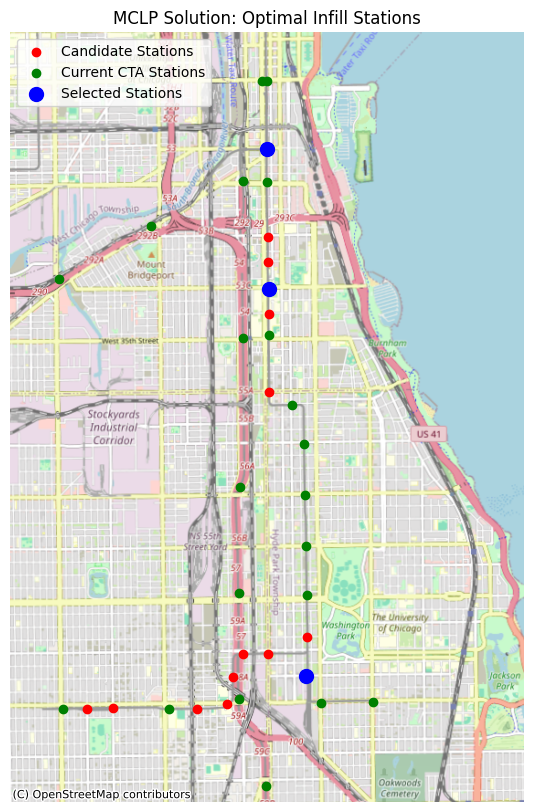

In [50]:
# Map the new infill stations

fig, ax = plt.subplots(figsize=(10, 10))
candidate_stations_gdf.plot(ax=ax, color='red', label='Candidate Stations')
selected_stations = candidate_stations_gdf[candidate_stations_gdf['mclp_dv'] == 1]
Current_L_SS.to_crs(nhgis_2020_merged.crs).plot(ax=ax, color='Green', label='Current CTA Stations')

ax.set_xlim(444000, 452000)
ax.set_ylim(4.624e6, 4.636e6)

ax.axis('off')

cx.add_basemap(selected_stations.plot(ax=ax, color='blue', markersize=100, label='Selected Stations'), crs=nhgis_2020_merged.crs, source=cx.providers.OpenStreetMap.Mapnik )
plt.legend(loc='upper left')
plt.title('MCLP Solution: Optimal Infill Stations')
plt.show()

In [51]:
# Extract the indices of selected facilities
selected_facilities = candidate_stations_gdf[candidate_stations_gdf['mclp_dv'] == 1].index

facility_coverage = {}

# Iterate over each selected facility
for facility_idx in selected_facilities:
    # Get the travel times  
    travel_times_from_facility = travel_times_matrix[:, facility_idx]
    
    # Determine census blocks within service radius
    covered_blocks = travel_times_from_facility <= SERVICE_RADIUS
    
    # Calculate  total population covered  
    covered_population = populations[covered_blocks].sum()
    facility_coverage[facility_idx] = covered_population

facility_coverage_df = pd.DataFrame.from_dict(facility_coverage, orient='index', columns=['covered_population'])

new_stations_infill = Infill_SSL.merge(facility_coverage_df, left_on = "id", right_index = True, how = "right")
print(new_stations_infill)

    index  id     LONGNAME     POINT_X      POINT_Y  \
7       7   7  61st Street  448617.641  4625962.937   
11     11  11         31st  448030.611  4632002.283   
14     14  14  18th Street  447997.522  4634175.764   

                          geometry  mclp_dv  covered_population  
7   POINT (448617.641 4625962.937)      1.0                4135  
11  POINT (448030.611 4632002.283)      1.0                3748  
14  POINT (447997.522 4634175.764)      1.0                6881  


#### Re-instituting branch service

In [32]:
# Load GeoDataFrames for transit stations and census blocks
candidate_stations_gdf = Branches_SSL

# Create travel time matrix
travel_time_matrix_computer =  TravelTimeMatrixComputer(
    transport_network_transit_Chi,
    origins=Branches_SSL,
    destinations=SS_15min_2020_points,
    departure=datetime.datetime(2023,12,22,8,30), 
    transport_modes=[TransportMode.WALK]
)
travel_time_matrix = travel_time_matrix_computer.compute_travel_times()

# Extract population data from the census blocks GeoDataFrame
census_blocks_gdf['population'] = census_blocks_gdf['U7H001']

In [33]:
# Pivot the travel times DataFrame to create a matrix
travel_times_matrix = travel_time_matrix.pivot(index='to_id', columns='from_id', values='travel_time')
travel_times_matrix = travel_times_matrix.fillna(float('inf'))
travel_times_matrix = travel_times_matrix.values

# Extract the population weights
populations = census_blocks_gdf.set_index('id')['population'].values

In [34]:
# Define the coverage distance and number of facilities
SERVICE_RADIUS = 10  # Adjust based on your specific requirements
P_FACILITIES = 6     # Number of facilities to be chosen

In [35]:
# Set solver
solver = pulp.GUROBI_CMD()

# Solve the MCLP
mclp_model = MCLP.from_cost_matrix(
    travel_times_matrix,
    populations,
    SERVICE_RADIUS,
    p_facilities=P_FACILITIES,
    name="MCLP-travel-time"
)

mclp_solution = mclp_model.solve(solver)
print(f"{mclp_solution.perc_cov}% coverage is observed")

# Map facility variables to candidate stations
decision_var_names = [var.name for var in mclp_solution.problem.variables()]
decision_var_values = [var.varValue for var in mclp_solution.problem.variables()]
decision_var_dict = dict(zip(decision_var_names, decision_var_values))

candidate_stations_gdf['mclp_dv'] = candidate_stations_gdf.index.map(lambda i: decision_var_dict.get(f"x_{i}_", 0))

Set parameter Username
Set parameter LogFile to value "gurobi.log"
Using license file /Users/hank/gurobi.lic
Academic license - for non-commercial use only - expires 2025-05-20

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 23.5.0 23F79)
Copyright (c) 2024, Gurobi Optimization, LLC

Read LP format model from file /var/folders/hy/7bg3p3w97zz61h5wn9hhp18h0000gn/T/ce26c96aa1234f5b95887c3457d9a8e4-pulp.lp
Reading time = 0.03 seconds
objective_function: 11743 rows, 11775 columns, 12909 nonzeros

CPU model: Intel(R) Core(TM) i5-8259U CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 11743 rows, 11775 columns and 12909 nonzeros
Model fingerprint: 0x6d1817d0
Variable types: 0 continuous, 11775 integer (11775 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+00, 6e+00]
Found heuristic solution: objective

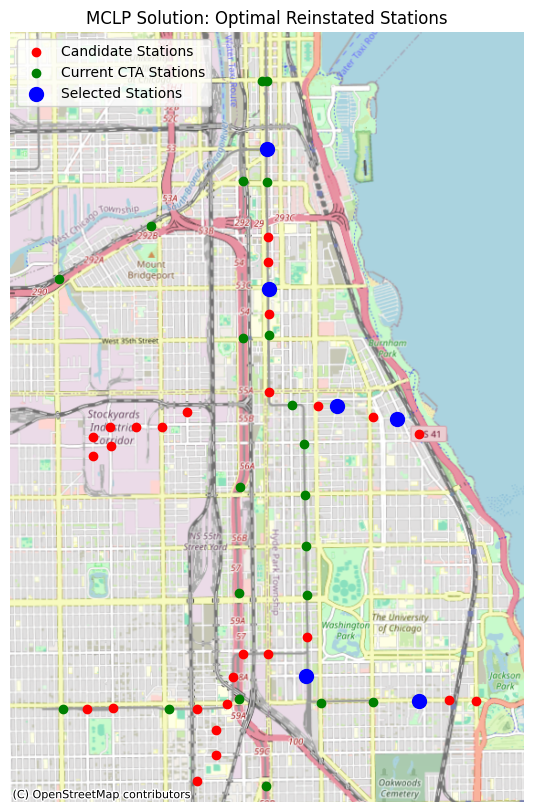

In [36]:
# Map the new infill stations - including branches 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
candidate_stations_gdf.plot(ax=ax, color='red', label='Candidate Stations')
selected_stations = candidate_stations_gdf[candidate_stations_gdf['mclp_dv'] == 1]
Current_L_SS.to_crs(nhgis_2020_merged.crs).plot(ax=ax, color='Green', label='Current CTA Stations')

ax.set_xlim(444000, 452000)
ax.set_ylim(4.624e6, 4.636e6)

ax.axis('off')

cx.add_basemap(selected_stations.plot(ax=ax, color='blue', markersize=100, label='Selected Stations'), crs=nhgis_2020_merged.crs, source=cx.providers.OpenStreetMap.Mapnik )
plt.legend(loc='upper left')
plt.title('MCLP Solution: Optimal Reinstated Stations')
plt.show()

In [45]:
# Extract the indices of selected facilities
selected_facilities = candidate_stations_gdf[candidate_stations_gdf['mclp_dv'] == 1].index

facility_coverage = {}

# Iterate over each selected facility
for facility_idx in selected_facilities:
    # Get the travel times  
    travel_times_from_facility = travel_times_matrix[:, facility_idx]
    
    # Determine census blocks within service radius
    covered_blocks = travel_times_from_facility <= SERVICE_RADIUS
    
    # Calculate  total population covered  
    covered_population = populations[covered_blocks].sum()
    facility_coverage[facility_idx] = covered_population

# Convert the result to a DataFrame for better visualization
facility_coverage_df = pd.DataFrame.from_dict(facility_coverage, orient='index', columns=['covered_population'])

new_stations_branches = Branches_SSL.merge(facility_coverage_df, left_on = "id", right_index = True, how = "right")

print(new_stations_branches)

    index  id         LONGNAME     POINT_X      POINT_Y  \
12     12  12       University  450367.242  4625581.030   
13     13  13      61st Street  448617.641  4625962.937   
16     16  16        Vincennes  449091.156  4630174.631   
18     18  18  Ellis/Lake Park  450034.203  4629970.580   
29     29  29             31st  448030.611  4632002.283   
32     32  32      18th Street  447997.522  4634175.764   

                          geometry  mclp_dv  covered_population  
12  POINT (450367.242 4625581.030)      1.0                6168  
13  POINT (448617.641 4625962.937)      1.0                4135  
16  POINT (449091.156 4630174.631)      1.0                4154  
18  POINT (450034.203 4629970.580)      1.0                3954  
29  POINT (448030.611 4632002.283)      1.0                3748  
32  POINT (447997.522 4634175.764)      1.0                6881  
